In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
df = pd.read_csv("bank-additional.csv", sep=';')
print(df.shape)
df.head()



(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df = df.drop(columns=["duration"])
print(df.shape)


(41188, 20)


In [5]:
df["y"] = df["y"].map({"yes": 1, "no": 0})
print(df["y"].value_counts())


y
0    36548
1     4640
Name: count, dtype: int64


In [6]:
cat_cols = df.select_dtypes(include="object").columns

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df.isna().sum().sum()


np.int64(0)

In [7]:
X = df.drop(columns=["y"])
y = df["y"]

print(X.shape, y.shape)


(41188, 19) (41188,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(28831, 19) (12357, 19)


In [9]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Decision Tree Accuracy: 0.8414663753338189
Confusion Matrix:
 [[9916 1049]
 [ 910  482]]


In [10]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Decision Tree Accuracy: 0.8414663753338189
Confusion Matrix:
 [[9916 1049]
 [ 910  482]]


In [11]:
results = []

for mf in ["sqrt", "log2", 5, 10]:
    rf = RandomForestClassifier(
        n_estimators=200,
        max_features=mf,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cost = fp*1 + fn*10

    results.append([mf, accuracy_score(y_test, y_pred), fp, fn, cost])

df_rf_results = pd.DataFrame(
    results,
    columns=["max_features", "Accuracy", "FP", "FN", "Cost"]
)

df_rf_results


,max_features,Accuracy,FP,FN,Cost
0,sqrt,0.896820,283,992,10203
1,log2,0.896820,283,992,10203
2,5,0.894311,312,994,10252
3,10,0.894149,333,975,10083


In [13]:
rf_final = RandomForestClassifier(
    n_estimators=200,
    max_features=10,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)

y_pred_rf_final = rf_final.predict(X_test)


In [15]:
rf_accuracy = accuracy_score(y_test, y_pred_rf_final)
rf_cm = confusion_matrix(y_test, y_pred_rf_final)

print("Final Random Forest Accuracy:", rf_accuracy)
print("Final Confusion Matrix:\n", rf_cm)


Final Random Forest Accuracy: 0.8941490653071134
Final Confusion Matrix:
 [[10632   333]
 [  975   417]]


In [16]:
tn, fp, fn, tp = rf_cm.ravel()
final_cost = fp*1 + fn*10

print("FP:", fp)
print("FN:", fn)
print("Final Cost:", final_cost)


FP: 333
FN: 975
Final Cost: 10083


In [17]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_final.feature_importances_
}).sort_values(by="Importance", ascending=False)

top_20_features = feature_importance.head(20)
top_20_features


,Feature,Importance
0,age,0.177837
17,euribor3m,0.143578
18,nr.employed,0.095630
1,job,0.084082
10,campaign,0.081058
3,education,0.075459
9,day_of_week,0.059070
2,marital,0.041164
5,housing,0.040550
11,pdays,0.038910


In [18]:
top_20_features.to_csv("rf_top_20_features.csv", index=False)


In [19]:
rf_cm_df = pd.DataFrame(
    rf_cm,
    index=["Actual No", "Actual Yes"],
    columns=["Predicted No", "Predicted Yes"]
)

rf_cm_df


,Predicted No,Predicted Yes
Actual No,10632,333
Actual Yes,975,417


In [20]:
rf_cm_df.to_csv("rf_final_confusion_matrix.csv")


In [21]:
dt_final = DecisionTreeClassifier(random_state=42)
dt_final.fit(X_train, y_train)

y_pred_dt_final = dt_final.predict(X_test)
dt_cm = confusion_matrix(y_test, y_pred_dt_final)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt_final))
print("Decision Tree Confusion Matrix:\n", dt_cm)


Decision Tree Accuracy: 0.8414663753338189
Decision Tree Confusion Matrix:
 [[9916 1049]
 [ 910  482]]


In [22]:
tn, fp, fn, tp = dt_cm.ravel()
dt_cost = fp*1 + fn*10

print("DT FP:", fp)
print("DT FN:", fn)
print("DT Cost:", dt_cost)


DT FP: 1049
DT FN: 910
DT Cost: 10149


In [23]:
df_cost_compare = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_dt_final),
        rf_accuracy
    ],
    "Cost": [
        dt_cost,
        final_cost
    ]
})

df_cost_compare


,Model,Accuracy,Cost
0,Decision Tree,0.841466,10149
1,Random Forest,0.894149,10083


In [24]:
df_cost_compare.to_csv("model_cost_comparison.csv", index=False)


In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [28]:
df = pd.read_csv("/content/bank-additional.csv", sep=";")
df.shape

(41188, 21)

In [31]:
df = df.drop(columns=["duration"], errors='ignore')
df.shape

(41188, 20)

In [32]:
le = LabelEncoder()

for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])


In [33]:
X = df.drop("y", axis=1)
y = df["y"]

X.shape, y.shape


((41188, 19), (41188,))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((28831, 19), (12357, 19))

In [36]:
def calculate_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0, 1]
    FN = cm[1, 0]
    cost = FP * 1 + FN * 10
    return FP, FN, cost


In [37]:
rf_results = []

for feature in ["sqrt", "log2", 5, 10]:
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_features=feature,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    FP, FN, cost = calculate_cost(y_test, y_pred)

    rf_results.append([feature, acc, FP, FN, cost])


In [38]:
df_rf_results = pd.DataFrame(
    rf_results,
    columns=["max_features", "Accuracy", "FP", "FN", "Cost"]
)

df_rf_results


,max_features,Accuracy,FP,FN,Cost
0,sqrt,0.896253,292,990,10192
1,log2,0.896253,292,990,10192
2,5,0.894149,312,996,10272
3,10,0.894149,331,977,10101


In [39]:
df_rf_results.to_csv("rf_tuning_results.csv", index=False)


In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(
    n_estimators=200,
    max_features=10,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)
y_pred_rf = rf_final.predict(X_test)


In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm_rf = confusion_matrix(y_test, y_pred_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)

cm_rf, acc_rf


(array([[10632,   333],
        [  975,   417]]),
 0.8941490653071134)

In [42]:
TN, FP, FN, TP = cm_rf.ravel()

cost_rf = FP * 1 + FN * 10

FP, FN, cost_rf


(np.int64(333), np.int64(975), np.int64(10083))

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10965
           1       0.56      0.30      0.39      1392

    accuracy                           0.89     12357
   macro avg       0.74      0.63      0.67     12357
weighted avg       0.88      0.89      0.88     12357



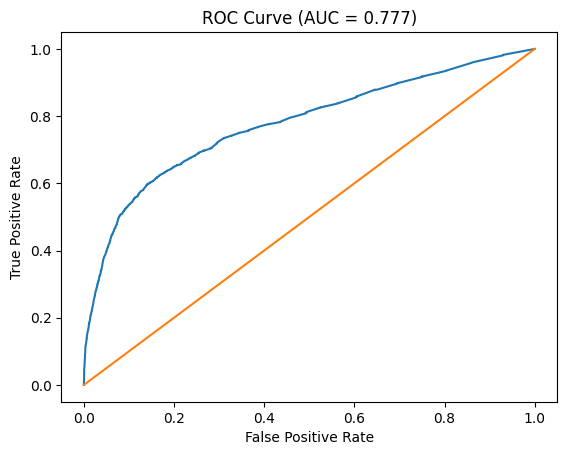

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_rf = rf_final.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()


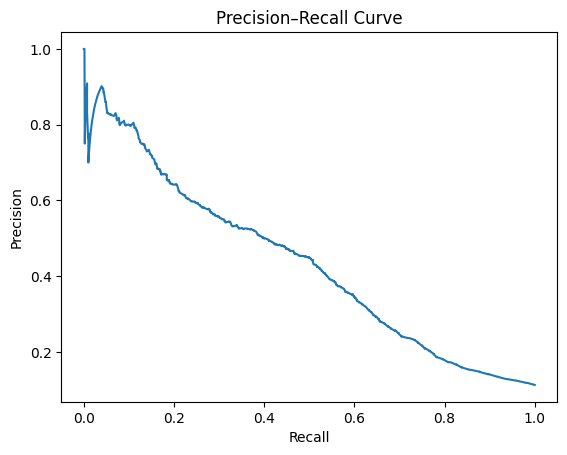

In [45]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


In [46]:
import pandas as pd
import numpy as np

importances = rf_final.feature_importances_
feature_names = X.columns

df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

df_top20 = df_importance.head(20)
df_top20


,Feature,Importance
0,age,0.177837
17,euribor3m,0.143578
18,nr.employed,0.095630
1,job,0.084082
10,campaign,0.081058
3,education,0.075459
9,day_of_week,0.059070
2,marital,0.041164
5,housing,0.040550
11,pdays,0.038910


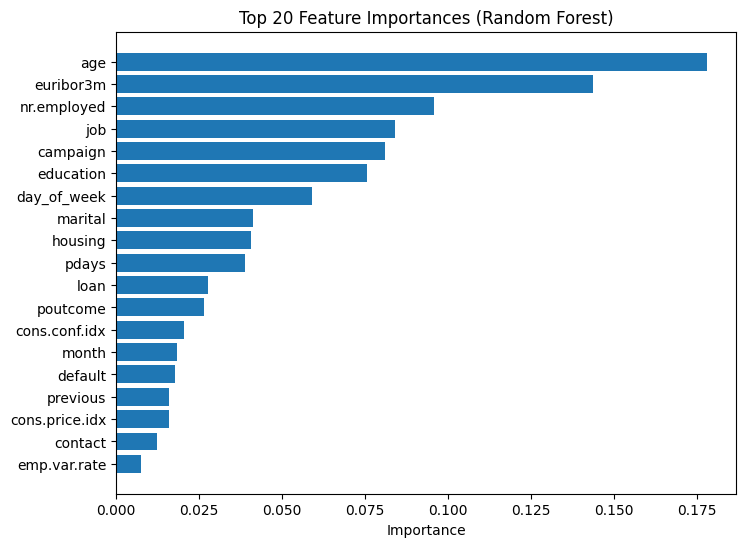

In [47]:
plt.figure(figsize=(8,6))
plt.barh(df_top20["Feature"], df_top20["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


In [48]:
df_top20.to_csv("rf_top20_features.csv", index=False)


In [49]:
!pip -q install xgboost lightgbm catboost imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [50]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [51]:
INCLUDE_DURATION = False  # set True if you want maximum accuracy (but it is leakage)


In [52]:
df_raw = pd.read_csv("bank-additional.csv", sep=";")

if not INCLUDE_DURATION and "duration" in df_raw.columns:
    df_raw = df_raw.drop(columns=["duration"])

df_raw["y"] = df_raw["y"].map({"yes": 1, "no": 0})

cat_cols = df_raw.select_dtypes(include="object").columns
le = LabelEncoder()
for col in cat_cols:
    df_raw[col] = le.fit_transform(df_raw[col])

X = df_raw.drop(columns=["y"])
y = df_raw["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((28831, 19), (12357, 19))

In [53]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train_sm.shape, y_train_sm.value_counts()


((51166, 19),
 y
 0    25583
 1    25583
 Name: count, dtype: int64)

In [54]:
xgb_model = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_model.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.8810390871570769
XGBoost Confusion Matrix:
 [[10246   719]
 [  751   641]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10965
           1       0.47      0.46      0.47      1392

    accuracy                           0.88     12357
   macro avg       0.70      0.70      0.70     12357
weighted avg       0.88      0.88      0.88     12357



In [55]:
lgbm_model = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=63,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

lgbm_model.fit(X_train_sm, y_train_sm)
y_pred_lgbm = lgbm_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("LightGBM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 25583, number of negative: 25583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 51166, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.8884033341425912
LightGBM Confusion Matrix:
 [[10383   582]
 [  797   595]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10965
           1       0.51      0.43      0.46      1392

    accuracy                           0.89     12357
   macro avg       0.72      0.69      0.70     12357
weighted avg       0.88      0.89      0.88     12357



In [56]:
cat_model = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.03,
    depth=6,
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train_sm, y_train_sm)
y_pred_cat = cat_model.predict(X_test)

print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cat))
print("CatBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))


CatBoost Accuracy: 0.8858137088290038
CatBoost Confusion Matrix:
 [[10255   710]
 [  701   691]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10965
           1       0.49      0.50      0.49      1392

    accuracy                           0.89     12357
   macro avg       0.71      0.72      0.72     12357
weighted avg       0.89      0.89      0.89     12357



In [57]:
df_final_compare = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgbm),
        accuracy_score(y_test, y_pred_cat)
    ]
})

df_final_compare


,Model,Accuracy
0,XGBoost,0.881039
1,LightGBM,0.888403
2,CatBoost,0.885814


In [58]:
df_final_compare = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgbm),
        accuracy_score(y_test, y_pred_cat)
    ]
})

df_final_compare


,Model,Accuracy
0,XGBoost,0.881039
1,LightGBM,0.888403
2,CatBoost,0.885814


In [59]:
INCLUDE_DURATION = True


In [60]:
df_raw = pd.read_csv("bank-additional.csv", sep=";")

df_raw["y"] = df_raw["y"].map({"yes": 1, "no": 0})

cat_cols = df_raw.select_dtypes(include="object").columns
le = LabelEncoder()
for col in cat_cols:
    df_raw[col] = le.fit_transform(df_raw[col])

X = df_raw.drop(columns=["y"])
y = df_raw["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X.shape


(41188, 20)

In [61]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

y_train_sm.value_counts()


,count
y,
0,25583
1,25583


In [62]:
xgb_model = XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.95,
    colsample_bytree=0.95,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_model.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9099295945617868
[[10348   617]
 [  496   896]]


In [63]:
lgbm_model = LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.02,
    num_leaves=127,
    max_depth=-1,
    subsample=0.95,
    colsample_bytree=0.95,
    random_state=42,
    n_jobs=-1
)

lgbm_model.fit(X_train_sm, y_train_sm)
y_pred_lgbm = lgbm_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 25583, number of negative: 25583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 51166, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.911952739338027
[[10404   561]
 [  527   865]]


In [64]:
cat_model = CatBoostClassifier(
    iterations=1500,
    depth=8,
    learning_rate=0.03,
    loss_function="Logloss",
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train_sm, y_train_sm)
y_pred_cat = cat_model.predict(X_test)

print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cat))
print(confusion_matrix(y_test, y_pred_cat))


CatBoost Accuracy: 0.9101723719349356
[[10325   640]
 [  470   922]]


In [65]:
df_accuracy_final = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgbm),
        accuracy_score(y_test, y_pred_cat)
    ]
})

df_accuracy_final


,Model,Accuracy
0,XGBoost,0.909930
1,LightGBM,0.911953
2,CatBoost,0.910172


In [66]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [67]:
df = pd.read_csv("bank-additional.csv", sep=";")
df["y"] = df["y"].map({"yes": 1, "no": 0})

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((28831, 20), (12357, 20))

In [68]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols[:5], len(cat_cols), len(num_cols)


(['job', 'marital', 'education', 'default', 'housing'], 10, 10)

In [69]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


In [70]:
lgbm = LGBMClassifier(
    n_estimators=4000,
    learning_rate=0.02,
    num_leaves=255,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

lgbm_pipe = Pipeline(steps=[("prep", preprocess), ("model", lgbm)])

lgbm_pipe.fit(X_train, y_train)
pred_lgbm = lgbm_pipe.predict(X_test)

print("OneHot LightGBM Accuracy:", accuracy_score(y_test, pred_lgbm))
print(confusion_matrix(y_test, pred_lgbm))


[LightGBM] [Info] Number of positive: 3248, number of negative: 25583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 28831, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112657 -> initscore=-2.063889
[LightGBM] [Info] Start training from score -2.063889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


OneHot LightGBM Accuracy: 0.9120336651290767
[[10524   441]
 [  646   746]]


In [71]:
xgb = XGBClassifier(
    n_estimators=2500,
    max_depth=8,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_pipe = Pipeline(steps=[("prep", preprocess), ("model", xgb)])

xgb_pipe.fit(X_train, y_train)
pred_xgb = xgb_pipe.predict(X_test)

print("OneHot XGBoost Accuracy:", accuracy_score(y_test, pred_xgb))
print(confusion_matrix(y_test, pred_xgb))


OneHot XGBoost Accuracy: 0.913004774621672
[[10507   458]
 [  617   775]]


In [72]:
xgb = XGBClassifier(
    n_estimators=2500,
    max_depth=8,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_pipe = Pipeline(steps=[("prep", preprocess), ("model", xgb)])

xgb_pipe.fit(X_train, y_train)
pred_xgb = xgb_pipe.predict(X_test)

print("OneHot XGBoost Accuracy:", accuracy_score(y_test, pred_xgb))
print(confusion_matrix(y_test, pred_xgb))


OneHot XGBoost Accuracy: 0.913004774621672
[[10507   458]
 [  617   775]]


In [73]:
from catboost import CatBoostClassifier

df_cb = pd.read_csv("bank-additional.csv", sep=";")
df_cb["y"] = df_cb["y"].map({"yes": 1, "no": 0})

X_cb = df_cb.drop(columns=["y"])
y_cb = df_cb["y"]

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(
    X_cb, y_cb, test_size=0.3, random_state=42, stratify=y_cb
)

cat_features_idx = np.where(X_train_cb.dtypes == "object")[0].tolist()

cat_model = CatBoostClassifier(
    iterations=4000,
    depth=8,
    learning_rate=0.03,
    loss_function="Logloss",
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train_cb, y_train_cb, cat_features=cat_features_idx)
pred_cat = cat_model.predict(X_test_cb)

print("CatBoost Accuracy:", accuracy_score(y_test_cb, pred_cat))
print(confusion_matrix(y_test_cb, pred_cat))


CatBoost Accuracy: 0.916079954681557
[[10570   395]
 [  642   750]]


In [74]:
compare = pd.DataFrame({
    "Model": ["OneHot LightGBM", "OneHot XGBoost", "CatBoost native"],
    "Accuracy": [
        accuracy_score(y_test, pred_lgbm),
        accuracy_score(y_test, pred_xgb),
        accuracy_score(y_test_cb, pred_cat),
    ]
})
compare


,Model,Accuracy
0,OneHot LightGBM,0.912034
1,OneHot XGBoost,0.913005
2,CatBoost native,0.916080
